In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

# import xgboost as xgb

import matplotlib.pyplot as plt
# plt.style.use("dark_background")
import seaborn as sns
# import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# reviews_sample.columns.str.strip().str.lower().str.replace(' ', '_')

# Part 2: Exploratory Social Network Analysis [20 points]

### (a) Load the directed network graph (G) from the file amazonNetwork.csv and draw a graph of the network. [2 points]

In [2]:
# loading the data
amz = pd.read_csv("amazonNetwork.csv")
amz

,FromNodeId,ToNodeId
0,1,2
1,1,4
2,1,5
3,1,15
4,2,11
...,...,...
10836,2646,980
10837,2647,881
10838,2647,976
10839,2647,978


In [3]:
# %pip install networkx
# %pip install networkx==2.5
import networkx as nx

In [4]:
# version of networkx
print("Networkx version: ", nx.__version__)

Networkx version:  2.5


In [5]:
# group by source and target and count the number of co-purchases
amz_grouped = amz.groupby(['FromNodeId', 'ToNodeId']).size().reset_index(name='Count')
amz_grouped.sample(3)

,FromNodeId,ToNodeId,Count
845,174,95,1
8615,1985,518,1
5897,1275,1274,1


In [6]:
G = nx.from_pandas_edgelist(amz_grouped, 'FromNodeId', 'ToNodeId', edge_attr='Count', create_using=nx.DiGraph())

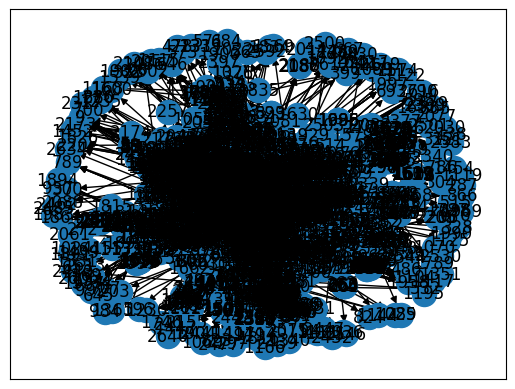

In [7]:
nx.draw_networkx(G)

### (b) How many items are present in the network and how many co-purchases happened? [2 points]

In [8]:
# create a list of nodes
nodes = list(amz.FromNodeId) + list(amz.ToNodeId)
nodes = list(set(nodes))
print("Number of items present in the network: ", len(nodes))

Number of items present in the network:  2647


In [9]:
# are there any non-single edges?
if amz_grouped[amz_grouped.Count > 1].empty:
    print("There are only single edges.")
else:
    print("There are non-single edges.")

There are only single edges.


In [10]:
# are there any self-loops?
if amz_grouped[amz_grouped.FromNodeId == amz_grouped.ToNodeId].empty:
    print("There are no self-loops.")
else:
    print("There are self-loops.")

There are no self-loops.


In [11]:
# no of co-purchases
print("Number of co-purchases: ", len(amz_grouped))

Number of co-purchases:  10841


As there are no self loops and all transactions are unique, the count of total transactions is the number of co-purchases.

In [12]:
nx.is_directed(G)

True

In [13]:
print("Number of items present in the network: ", G.number_of_nodes())
print("Number of co-purchases: ", G.number_of_edges())

Number of items present in the network:  2647
Number of co-purchases:  10841


### (c) Compute the average shortest distance between the nodes in graph G. Explain your results briefly. [2 points]

In [14]:
# Calculate average shortest distance
print("Average shortest distance: ", nx.average_shortest_path_length(G))

Average shortest distance:  9.592795477759587


### (d) Compute the transitivity, the average clustering coefficient, density, and degree assortativity of the network graph G. Explain your findings briefly based on the definitions. [4 points]

In [15]:
# transitivity
transitivity = nx.transitivity(G)

# average clustering coefficient
avg_clustering_coefficient = nx.average_clustering(G)

# density
density = nx.density(G)

# degree assortativity coefficient
assortativity_coefficient = nx.degree_assortativity_coefficient(G)

print("Transitivity: ", transitivity)
print("Average clustering coefficient: ", avg_clustering_coefficient)
print("Density: ", density)
print("Degree assortativity coefficient:", assortativity_coefficient)

Transitivity:  0.4339169154480595
Average clustering coefficient:  0.4086089178720651
Density:  0.0015478382092878288
Degree assortativity coefficient: 0.060674284680185056


### (e) Apply the PageRank algorithm to network G with damping value 0.5 and find the 10 nodes with the highest PageRank. Explain your findings briefly. [5 points]

In [16]:
pagerank = nx.pagerank(G, alpha=0.5)
pagerank = pd.DataFrame(pagerank.items(), columns=['Node', 'PageRank'])
pagerank = pagerank.sort_values(by=['PageRank'], ascending=False)
pagerank.head(10)

,Node,PageRank
21,8,0.003625
397,481,0.002434
55,33,0.002297
18,18,0.002103
29,23,0.002079
25,30,0.001882
390,346,0.001863
147,99,0.001820
101,93,0.001792
27,21,0.001659


### (f) Perform the average neighbor degree, closeness centrality, and edge betweenness centrality. Report the top 10 results with the highest value for each analysis and briefly explain your findings. [5 points]

In [17]:
# average neighbor degree
avg_neighbor_degree = nx.average_neighbor_degree(G)
avg_neighbor_degree = pd.DataFrame(avg_neighbor_degree.items(), columns=['Node', 'AvgNeighborDegree'])
avg_neighbor_degree.sort_values(by=['AvgNeighborDegree'], ascending=False).head(10)

,Node,AvgNeighborDegree
1323,1766,5.0
859,570,5.0
867,772,5.0
1927,1497,5.0
1930,1500,5.0
1940,1957,5.0
863,827,5.0
861,770,5.0
1943,1961,5.0
858,1670,5.0


In [18]:
# closeness centrality
closeness_centrality = nx.closeness_centrality(G)
closeness_centrality = pd.DataFrame(closeness_centrality.items(), columns=['Node', 'ClosenessCentrality'])
closeness_centrality.sort_values(by=['ClosenessCentrality'], ascending=False).head(10)

,Node,ClosenessCentrality
21,8,0.195165
29,23,0.169903
27,21,0.169572
7,13,0.167177
25,30,0.163012
28,22,0.162313
55,33,0.160985
24,20,0.159604
30,24,0.157453
65,111,0.151386


In [19]:
# edge betweenness centrality
edge_betweenness_centrality = nx.edge_betweenness_centrality(G)
edge_betweenness_centrality = pd.DataFrame(edge_betweenness_centrality.items(), columns=['Node', 'EdgeBetweennessCentrality'])
edge_betweenness_centrality.sort_values(by=['EdgeBetweennessCentrality'], ascending=False).head(10)

,Node,EdgeBetweennessCentrality
88,"(18, 32)",0.080285
1922,"(481, 18)",0.078336
546,"(97, 117)",0.077862
256,"(32, 150)",0.063998
105,"(8, 22)",0.057861
928,"(170, 214)",0.050606
515,"(54, 84)",0.049810
1596,"(214, 651)",0.049565
251,"(31, 85)",0.048332
295,"(37, 97)",0.045669


In [20]:
# node betweenness
node_betweenness = nx.betweenness_centrality(G)
node_betweenness  = pd.DataFrame(node_betweenness.items(), columns=['Node', 'NodeBetweennessCentrality'])
node_betweenness.sort_values(by=['NodeBetweennessCentrality'], ascending=False).head(10)

,Node,NodeBetweennessCentrality
18,18,0.147551
21,8,0.140649
113,97,0.128843
206,117,0.103595
397,481,0.092957
25,30,0.085036
54,32,0.084182
99,150,0.083952
193,170,0.080242
28,22,0.072013


In [21]:
node_clustering = nx.clustering(G)
node_clustering  = pd.DataFrame(node_clustering.items(), columns=['Node', 'NodeClustering'])
node_clustering.sort_values(by=['NodeClustering'], ascending=False).head(10)

,Node,NodeClustering
1759,1073,1.0
2453,2217,1.0
2178,1622,1.0
2560,2327,1.0
1822,1910,1.0
1205,1294,1.0
1208,1297,1.0
1816,1443,1.0
2016,2392,1.0
2099,2445,1.0


Sure, here are brief definitions for each:

1. **Average Shortest Distance of Network:**
   - The average shortest distance measures the average number of steps it takes to travel from one node to another in a network, providing an indication of network-wide connectivity.

2. **Transitivity:**
   - Transitivity quantifies the tendency of nodes in a network to form clusters or triangles. It is the ratio of the number of triangles to the number of potential triangles in the network.

3. **Average Clustering Coefficient:**
   - The average clustering coefficient measures the degree to which nodes in a network tend to cluster together. It is the average of the local clustering coefficients for all nodes.

4. **Density:**
   - Density in a network context represents the ratio of actual edges to possible edges. It provides an indication of how connected the nodes are in the network.

4. **Degree Assortativity Coefficient:**
   - A positive coefficient (closer to 1) indicates assortative mixing, where nodes tend to connect to others with similar degrees. High-degree nodes are more likely to be connected to other high-degree nodes, and low-degree nodes to other low-degree nodes.

5. **Pagerank:**
   - Pagerank is an algorithm that assigns a numerical weight to each element in a hyperlinked set of documents, representing its importance in the network. It is commonly used for ranking web pages in search engines.

6. **Average Neighbor Degree:**
   - Average Neighbor Degree measures the average degree of the neighbors of a node in a network, providing insights into the local structure around each node.

7. **Closeness Centrality:**
   - Closeness centrality quantifies how close a node is to all other nodes in the network. Nodes with high closeness centrality can be reached quickly from other nodes.

8. **Edge Betweenness Centrality:**
   - Edge Betweenness Centrality measures the number of shortest paths between pairs of nodes that pass through a particular edge. It helps identify critical edges for communication in the network.

9. **Node Betweenness Centrality:**
   - Node Betweenness Centrality measures the influence of a node in a network by quantifying the number of shortest paths that pass through it. Nodes with high betweenness centrality are crucial for maintaining efficient communication in the network. It is often employed in identifying critical nodes whose removal might disrupt communication or flow within a network.

10. **Node-Level Clustering Coefficient:**
      - Node-Level Clustering Coefficient measures the extent to which neighbors of a node are connected to each other. It quantifies the local clustering around a node, reflecting how well its neighbors are interconnected. High node-level clustering indicates that a node's neighbors are densely connected, suggesting a tightly-knit local community or module.

In [22]:
# combine the dataframes
graph_df = node_clustering.join(node_betweenness.set_index('Node'), on='Node')\
    .join(closeness_centrality.set_index('Node'), on='Node')\
    .join(avg_neighbor_degree.set_index('Node'), on='Node')\
    .join(pagerank.set_index('Node'), on='Node')
graph_df.sort_values(by=['Node'], ascending=True).head(10)

,Node,NodeClustering,NodeBetweennessCentrality,ClosenessCentrality,AvgNeighborDegree,PageRank
0,1,0.000000,0.000000,0.000000,4.75,0.000197
1,2,0.050000,0.000084,0.000378,5.00,0.000222
9,3,0.450000,0.000000,0.000000,5.00,0.000197
2,4,0.188830,0.005049,0.065922,5.00,0.000699
3,5,0.142157,0.004032,0.133688,4.00,0.000774
20,6,0.102649,0.008260,0.147774,4.00,0.000979
15,7,0.109562,0.018768,0.150353,4.00,0.001263
21,8,0.039888,0.140649,0.195165,5.00,0.003625
22,9,0.082418,0.000000,0.146580,0.00,0.001137
23,10,0.285714,0.003049,0.116834,4.00,0.000424


# Part 3: Predicting Review-Rating using Features derived from network properties [50 points]

In [209]:
reviewTrain = pd.read_csv("reviewTrain.csv")
reviewTrain.head(3)

,id,title,group,review
0,3,World War II Allied Fighter Planes Trading Cards,Book,5.0
1,5,Prayers That Avail Much for Business: Executive,Book,0.0
2,7,Batik,Music,4.5


In [215]:
def preprocess(input_df):
    df = input_df.merge(graph_df, left_on='id', right_on='Node', how='left')
    # drop columns
    df_X = df.drop(['id', 'title', 'group', 'Node', 'review'], axis=1)
    # convert the review column to string
    df['review'] = df['review'].astype(str)
    df_y = df['review'].astype(float)
    # fill nan values
    df_X = df_X.fillna(df_X.median())
    df_y = df_y.fillna(df_y.median())
    return df_X, df_y

X, y= preprocess(reviewTrain)

In [216]:
X

,NodeClustering,NodeBetweennessCentrality,ClosenessCentrality,AvgNeighborDegree,PageRank
0,0.450000,0.000000,0.000000,5.0,0.000197
1,0.142157,0.004032,0.133688,4.0,0.000774
2,0.109562,0.018768,0.150353,4.0,0.001263
3,0.285714,0.003049,0.116834,4.0,0.000424
4,0.120344,0.008756,0.008231,3.8,0.000906
...,...,...,...,...,...
1669,0.368421,0.000533,0.070014,4.8,0.000344
1670,0.368421,0.000533,0.070014,4.8,0.000344
1671,0.368421,0.000533,0.070014,4.8,0.000344
1672,0.368421,0.000533,0.070014,4.8,0.000344


In [212]:
# perform mutual information feature selection
from sklearn.feature_selection import mutual_info_regression

# mutual information
mi = mutual_info_regression(X, y)
mi = pd.DataFrame(mi, columns=['MI'])
mi['Feature'] = X.columns
mi = mi.sort_values(by=['MI'], ascending=False)
mi.head(10)

,MI,Feature
3,0.008028,AvgNeighborDegree
1,0.006700,NodeBetweennessCentrality
2,0.004379,ClosenessCentrality
0,0.000000,NodeClustering
4,0.000000,PageRank


Since the `NodeClustering` and `PageRank` do not convey any information about the `y` variable of `reviews`, I will drop them.

In [217]:
X = X.drop(['NodeClustering', 'PageRank'], axis=1)

In [218]:
y

0       5.0
1       0.0
2       4.5
3       4.0
4       5.0
       ... 
1669    0.0
1670    4.5
1671    5.0
1672    4.5
1673    3.5
Name: review, Length: 1674, dtype: float64

I will scale the feature dataset with `StandardScalar` and apply various machine Learning models over it.

In [219]:
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def get_MAE_score(model, X_train_scaled, X_test_scaled, y_train, y_test):
    model.fit(X_train_scaled, y_train)
    print("Training score: ", mean_absolute_error(y_train, model.predict(X_train_scaled)))
    y_pred = model.predict(X_test_scaled)
    return mean_absolute_error(y_test, y_pred)

First I will train the basic Linear Regression model.

In [220]:
lr = LinearRegression()
print("Test MAE Score: ", get_MAE_score(lr, X_train_scaled, X_test_scaled, y_train, y_test))

Training score:  1.7370778168322287
Test MAE Score:  1.68235069170558


In [221]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

lr = LinearRegression()
print("Test MAE Score: ", get_MAE_score(lr, X_train_poly, X_test_poly, y_train, y_test))

Training score:  1.7336777700711095
Test MAE Score:  1.6794445834155296


The polynomial model of degree 2 is computationally expensive and at the same time does not give a better imporvement of MAE score

In [222]:
model = SVR(kernel='rbf', C=1e3, gamma=0.1)
print("Test MAE Score: ", get_MAE_score(model, X_train_scaled, X_test_scaled, y_train, y_test))

Training score:  1.4735802473064286
Test MAE Score:  1.4031339356456516


SVR model gave the best MAE scores among these models

In [223]:
# predictions on test data
reviewTest = pd.read_csv("reviewTest.csv")

In [224]:
reviewTest.tail()

,id,title,group,review
995,1097,Ahma,Music,NaN
996,1393,Loney Planet Chicago City Map (City Maps Series),Book,NaN
997,643,Swell Style : A Girl's Guide to Turning Heads...,Book,NaN
998,976,Dark Continent : Europe's Twentieth Century,Book,NaN
999,961,Choice and Consequence,Book,NaN


In [225]:
reviewTest.fillna(0, inplace=True)
test_X, test_y = preprocess(reviewTest)

In [226]:
test_X

,NodeClustering,NodeBetweennessCentrality,ClosenessCentrality,AvgNeighborDegree,PageRank
0,0.250000,3.048563e-02,0.116428,5.0,0.000347
1,0.288462,9.535202e-03,0.080232,4.8,0.000300
2,0.750000,3.095826e-07,0.063412,5.0,0.000338
3,0.750000,1.031101e-04,0.072458,4.0,0.000268
4,0.562500,7.927132e-04,0.093620,5.0,0.000358
...,...,...,...,...,...
995,0.414634,1.646917e-03,0.064222,5.0,0.000454
996,0.315789,6.684665e-06,0.078876,4.5,0.000327
997,0.550000,1.315945e-03,0.093544,5.0,0.000398
998,0.101604,9.521942e-03,0.085334,4.8,0.001183


In [227]:
test_X = test_X.drop(['NodeClustering', 'PageRank'], axis=1)
test_X_scaled = scaler.transform(test_X)
test_y_pred = model.predict(test_X_scaled)

In [228]:
len(test_y_pred)

1000

In [229]:
reviewTest.review = test_y_pred
reviewTest.head()

,id,title,group,review
0,90,The Eagle Has Landed,Book,4.708739
1,1372,Che in Africa: Che Guevara's Congo Diary,Book,4.557368
2,1382,The Darwin Awards II : Unnatural Selection,Book,4.190920
3,253,Celtic Glory,Music,3.948070
4,671,Sublte Aromatherapy,Book,3.967436


In [230]:
reviewTest.to_csv("reviewTest_outcome.csv", index=False)

Obtained `review` predictions for `reviewTest.csv`